In [1]:
# Auto-install PyTorch with GPU support (Windows)
# This cell will try to detect the GPU / CUDA version and install a matching PyTorch build.
# Run this cell once in the notebook environment (you might need to restart the kernel after install).

import sys
import subprocess
import shutil
import re

# If you're running Python 3.12+ this automatic pip install will likely install a CPU-only build
# because official CUDA-enabled wheels may not be published for 3.12/3.13. In that case this cell
# will stop before attempting the install and print recommended steps (conda env with python=3.11).
if sys.version_info.major == 3 and sys.version_info.minor >= 12:
    print(f"Detected Python {sys.version_info.major}.{sys.version_info.minor} — automatic GPU wheel install will be skipped.")
    print("Recommended: create a conda environment with Python 3.11 (or a Python version supported by PyTorch wheels) and install cuda-enabled PyTorch there.")
    print("If you still want to attempt pip install anyway, set FORCE_PIP_INSTALL = True below and re-run this cell.")
    FORCE_PIP_INSTALL = False
else:
    FORCE_PIP_INSTALL = True


def run_cmd(cmd):
    print('Running:', ' '.join(cmd))
    subprocess.check_call(cmd)


def find_nvidia_smi():
    return shutil.which('nvidia-smi')

# Map CUDA major version to the PyTorch wheel tag
cuda_map = {'12': 'cu121', '11': 'cu118'}

nvidia = find_nvidia_smi()
cuda_tag = None
if nvidia:
    try:
        # Try querying nvidia-smi for cuda_version (may work on newer drivers)
        out = subprocess.check_output([nvidia, '--query-gpu=driver_version,cuda_version', '--format=csv,noheader'], stderr=subprocess.STDOUT, text=True)
        # example: "535.86.10,12.1"
        m = re.search(r'(\d+)\.(\d+)', out)
        if m:
            major = m.group(1)
            cuda_tag = cuda_map.get(major)
    except Exception:
        try:
            # Fallback: parse the nvidia-smi textual output
            out = subprocess.check_output([nvidia], stderr=subprocess.STDOUT, text=True)
            m = re.search(r'CUDA Version:\s*(\d+)\.(\d+)', out)
            if m:
                major = m.group(1)
                cuda_tag = cuda_map.get(major)
        except Exception:
            cuda_tag = None

if cuda_tag is None:
    print('\nCould not reliably detect CUDA version via nvidia-smi. Defaulting to cu118 (CUDA 11.8).')
    print('If your system has CUDA 12.x, set cuda_tag = "cu121" and re-run this cell before installing.')
    cuda_tag = 'cu118'

print('Selected PyTorch build tag:', cuda_tag)

if not FORCE_PIP_INSTALL:
    print('\nSkipping automatic pip install due to Python version.')
    print('Suggested next steps:')
    print(' - If you have conda:')
    print('    conda create -n mri-pytorch python=3.11 -y')
    print('    conda activate mri-pytorch')
    print('    conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia -y')
    print(' - Or install Python 3.11, create a venv and pip install with the appropriate --index-url for the CUDA tag.')
else:
    # Upgrade pip first
    try:
        run_cmd([sys.executable, '-m', 'pip', 'install', '--upgrade', 'pip'])
    except subprocess.CalledProcessError as e:
        print('pip upgrade failed:', e)

    # Install PyTorch + vision + audio from official PyTorch index for the chosen CUDA
    index_url = f'https://download.pytorch.org/whl/{cuda_tag}'
    try:
        run_cmd([sys.executable, '-m', 'pip', 'install', 'torch', 'torchvision', 'torchaudio', '--index-url', index_url])
    except subprocess.CalledProcessError as e:
        print('\nInstallation failed with error:', e)
        print('If this fails, consider selecting a different CUDA tag (cu121 vs cu118) or installing manually using https://pytorch.org/get-started/locally/')

    # Verify import and CUDA availability
    try:
        import torch
        print('\nVerification:')
        print('torch.__version__ =', torch.__version__)
        print('torch.version.cuda =', torch.version.cuda)
        print('torch.cuda.is_available() =', torch.cuda.is_available())
        try:
            print('GPU device count =', torch.cuda.device_count())
            if torch.cuda.is_available():
                print('Current device name =', torch.cuda.get_device_name(0))
        except Exception:
            pass
    except Exception as e:
        print('\nImport failed:', e)
        print('You may need to restart the notebook kernel or run this cell from the same Python environment where packages were installed.')

    print('\nDone. If PyTorch was just installed, restart the kernel and re-run your notebook cells that use torch.')


Detected Python 3.12 — automatic GPU wheel install will be skipped.
Recommended: create a conda environment with Python 3.11 (or a Python version supported by PyTorch wheels) and install cuda-enabled PyTorch there.
If you still want to attempt pip install anyway, set FORCE_PIP_INSTALL = True below and re-run this cell.
Selected PyTorch build tag: cu121

Skipping automatic pip install due to Python version.
Suggested next steps:
 - If you have conda:
    conda create -n mri-pytorch python=3.11 -y
    conda activate mri-pytorch
    conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia -y
 - Or install Python 3.11, create a venv and pip install with the appropriate --index-url for the CUDA tag.
Selected PyTorch build tag: cu121

Skipping automatic pip install due to Python version.
Suggested next steps:
 - If you have conda:
    conda create -n mri-pytorch python=3.11 -y
    conda activate mri-pytorch
    conda install pytorch torchvision torchaudio pytorch-c


# Unsupervised MRI Anomaly Detection (Conv Autoencoder)

**Goal:** Train a convolutional autoencoder **only on normal MRIs** to learn "what looks normal". At inference, images that reconstruct poorly (high reconstruction error) are flagged as **anomalies**.  
We'll evaluate using the provided labels (`Class`: 0 = normal, 1 = tumor) **only for validation/testing**, not for training the unsupervised model.

**What this notebook does:**
- Loads the **Brain Tumor.csv** metadata and pairs rows to image files named like `Image1`, `Image2`, ...
- Builds **train/val/test** splits (train+val use only normal images; test includes both normal & tumor).
- Trains a **Conv Autoencoder** on normal images.
- Sets an anomaly threshold from validation normals (e.g., 95th percentile).
- Evaluates on test (AUC, F1, precision/recall) and visualizes reconstructions & error maps.
- Supports **subsampling** for quick runs.


In [2]:
# --- Setup
import os, sys, math, random, time, json
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

# GPU Setup and Info
def setup_gpu():
    if torch.cuda.is_available():
        # Get GPU information
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        
        # Enable TF32 for better performance on Ampere GPUs
        torch.backends.cuda.matmul.allow_tf32 = True
        # Enable TF32 for convolution/cudnn
        torch.backends.cudnn.allow_tf32 = True
        
        # Enable cudnn benchmarking for better performance
        torch.backends.cudnn.benchmark = True
        
        # Print GPU info
        print(f"GPU: {gpu_name}")
        print(f"Total GPU Memory: {gpu_memory:.2f} GB")
        print("CUDA Version:", torch.version.cuda)
        try:
            print("cuDNN Version:", cudnn.version())
        except Exception:
            # Some torch builds expose version differently
            print("cuDNN Version: unknown")
        return True
    else:
        print("No GPU available, using CPU")
        return False

# Set device and optimize GPU settings if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_gpu = setup_gpu()  # This needs to be a global variable

# Rest of your imports and setup code...
# Custom transforms to replace torchvision
class CustomTransform:
    def __init__(self, size, augment=False):
        # Accept tuple or single int
        self.size = size[0] if isinstance(size, tuple) else size
        self.augment = augment
    
    def __call__(self, img):
        # Input: PIL Image
        img = img.convert('L')  # ensure grayscale PIL

        # Optional augmentations using PIL (keeps everything on CPU)
        if self.augment:
            # Random rotation (-10 to 10 degrees)
            if random.random() > 0.5:
                angle = random.uniform(-10, 10)
                img = img.rotate(angle, resample=Image.BICUBIC)

            # Random horizontal flip
            if random.random() > 0.5:
                img = ImageOps.mirror(img)

            # Small random intensity shifts
            if random.random() > 0.5:
                arr = np.array(img).astype(np.float32)
                shift = random.uniform(-0.1, 0.1)
                arr = arr * (1.0 + shift)
                arr = np.clip(arr, 0, 255).astype(np.uint8)
                img = Image.fromarray(arr)

        # Resize & center-crop to target size while preserving aspect ratio
        img = ImageOps.fit(img, (self.size, self.size), method=Image.BICUBIC, centering=(0.5, 0.5))

        # Convert to numpy and to torch tensor (C,H,W) with values in [-1,1]
        arr = np.array(img).astype(np.float32)
        tensor = torch.from_numpy(arr).unsqueeze(0)  # shape (1, H, W)
        tensor = tensor / 127.5 - 1.0  # normalize to [-1,1]

        return tensor


GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Total GPU Memory: 6.44 GB
CUDA Version: 12.1
cuDNN Version: 90100


In [3]:
# ==== CONFIG (edit these) =====================================================
RAW_DIR = r"C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\Brain Tumor"   # folder that contains imageXXXX files
CSV_PATHS = [
    r"C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\bt_dataset_t3.csv",
    r"C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\Brain Tumor.csv",
]  # can be .csv or .xlsx
CLEAN_DIR = RAW_DIR + "_clean"
IMG_SIZE = (256, 256)  # target H, W
ALLOWED_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
CLIP_PERCENTILES = (1, 99)  # robust normalization
MIN_NONZERO_FRACTION = 0.01  # drop if <1% nonzero pixels
MIN_DYNAMIC_RANGE = 5        # drop if p99 - p1 < 5 on [0..255]
# ============================================================================

import os, re, math, shutil, glob, pathlib, warnings
from typing import Optional, Tuple, Dict, Set
import numpy as np
import pandas as pd
from PIL import Image, ImageOps

# Ensure tqdm is available; install at runtime if missing
try:
    from tqdm import tqdm
except Exception:
    import sys, subprocess
    print('tqdm not installed; attempting to install via pip...')
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tqdm'])
        from tqdm import tqdm
        print('tqdm installed successfully')
    except Exception as e:
        print('Failed to install tqdm automatically:', e)
        # Fall back to a simple progress function
        def tqdm(x, **kwargs):
            return x

os.makedirs(CLEAN_DIR, exist_ok=True)

ID_REGEX = re.compile(r"(image[_\s-]*)(\d+)", re.IGNORECASE)

def extract_image_id_from_name(name: str) -> Optional[str]:
    """Return canonical id like 'image1234' (no extension), or None."""
    if not isinstance(name, str): 
        return None
    m = ID_REGEX.search(name)
    if not m:
        return None
    return f"image{int(m.group(2))}"  # normalize: no leading zeros

def is_image_file(path: str) -> bool:
    return pathlib.Path(path).suffix.lower() in ALLOWED_EXTS

def load_image_grayscale(path: str) -> Optional[Image.Image]:
    try:
        img = Image.open(path)
        img = ImageOps.exif_transpose(img)  # handle orientation flags
        if img.mode not in ("L", "I;16", "I", "F"):
            img = img.convert("L")
        return img
    except Exception:
        return None

def pad_to_square(img: Image.Image, fill=0) -> Image.Image:
    w, h = img.size
    if w == h:
        return img
    side = max(w, h)
    delta_w, delta_h = side - w, side - h
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    return ImageOps.expand(img, padding, fill=fill)

def normalize_uint8(arr: np.ndarray, clip_percentiles=(1, 99)) -> np.ndarray:
    """
    Robustly scale to 0..255 uint8 using percentiles (on nonzero pixels if present).
    """
    a = arr.astype(np.float32)
    mask = a > 0
    if mask.sum() >= 16:
        lo = np.percentile(a[mask], clip_percentiles[0])
        hi = np.percentile(a[mask], clip_percentiles[1])
    else:
        lo = np.percentile(a, clip_percentiles[0])
        hi = np.percentile(a, clip_percentiles[1])
    if hi <= lo:
        hi = lo + 1.0
    a = np.clip((a - lo) / (hi - lo), 0.0, 1.0)
    a = (a * 255.0).round().astype(np.uint8)
    return a

def should_discard(arr_uint8: np.ndarray) -> Optional[str]:
    """
    Heuristics to drop unusable images.
    """
    nz_frac = np.count_nonzero(arr_uint8) / arr_uint8.size
    if nz_frac < MIN_NONZERO_FRACTION:
        return f"too_blank(nz_frac={nz_frac:.4f})"
    p1 = np.percentile(arr_uint8, 1)
    p99 = np.percentile(arr_uint8, 99)
    if (p99 - p1) < MIN_DYNAMIC_RANGE:
        return f"low_dynamic_range({p99 - p1:.2f})"
    h, w = arr_uint8.shape[:2]
    if min(h, w) < 32:
        return f"too_small({w}x{h})"
    return None

def clean_and_save_image(src_path: str, dst_dir: str, img_id: str, img_size=(256, 256)) -> Tuple[bool, Optional[str], Optional[str]]:
    """
    Returns (kept, dst_path, reason_if_dropped)
    """
    img = load_image_grayscale(src_path)
    if img is None:
        return False, None, "read_error"

    img = pad_to_square(img, fill=0)
    img = img.resize((img_size[1], img_size[0]), resample=Image.BICUBIC)

    arr = np.array(img)
    arr = normalize_uint8(arr, clip_percentiles=CLIP_PERCENTILES)

    reason = should_discard(arr)
    if reason:
        return False, None, reason

    out_name = f"{img_id}.png"  # canonical cleaned name
    dst_path = os.path.join(dst_dir, out_name)
    Image.fromarray(arr, mode="L").save(dst_path, format="PNG")
    return True, dst_path, None

# 1) Index all candidate images in RAW_DIR
all_files = [p for p in glob.glob(os.path.join(RAW_DIR, "**", "*.*"), recursive=True) if is_image_file(p)]
records = []  # for audit
kept_ids: Set[str] = set()
id_to_clean_path: Dict[str, str] = {}

print(f"Found {len(all_files)} image files in: {RAW_DIR}")
for p in tqdm(all_files, desc="Cleaning images"):
    fname = os.path.basename(p)
    img_id = extract_image_id_from_name(fname)
    if not img_id:
        # skip files that don't match imageXXXX pattern
        records.append({"raw_path": p, "img_id": None, "kept": False, "reason": "id_not_matched"})
        continue
    kept, out_path, reason = clean_and_save_image(p, CLEAN_DIR, img_id, img_size=IMG_SIZE)
    records.append({"raw_path": p, "img_id": img_id, "kept": kept, "reason": reason, "clean_path": out_path})
    if kept and out_path:
        kept_ids.add(img_id)
        id_to_clean_path[img_id] = out_path

audit_df = pd.DataFrame(records)
audit_csv = os.path.join(CLEAN_DIR, "_cleaning_audit.csv")
audit_df.to_csv(audit_csv, index=False)
print(f"\nCleaning audit saved to: {audit_csv}")
print(f"Kept images: {sum(audit_df['kept']==True)} | Discarded: {sum(audit_df['kept']==False)}")

# 2) Helper to extract image ids from a dataframe
def infer_image_id_column(df: pd.DataFrame) -> pd.Series:
    """
    Return a Series of image ids ('image1234') inferred from common columns,
    or by scanning string columns for the pattern.
    """
    candidate_cols = [c for c in df.columns if c.lower() in ("filepath", "path", "file", "filename", "image", "img", "img_path")]
    for c in candidate_cols:
        s = df[c].astype(str).map(extract_image_id_from_name)
        if s.notna().any():
            return s

    # Fallback: scan all object columns
    obj_cols = df.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        s = df[c].astype(str).map(extract_image_id_from_name)
        if s.notna().any():
            return s

    # If nothing found, return an all-NA series
    return pd.Series([None]*len(df), index=df.index, name="image_id")

def update_path_columns(df: pd.DataFrame, id_to_path: Dict[str, str]) -> pd.DataFrame:
    """
    If a 'filepath' or similar column exists, update it to cleaned paths (PNG).
    If not, add 'clean_filepath'.
    """
    updated = df.copy()
    # Map image ids first
    image_ids = infer_image_id_column(updated)
    updated["_image_id"] = image_ids

    # Filter to kept ids
    mask = updated["_image_id"].isin(kept_ids)
    dropped = (~mask).sum()
    updated = updated[mask].copy()

    # Path columns to attempt updating
    path_like = [c for c in updated.columns if c.lower() in ("filepath", "path", "file", "filename", "img_path")]
    if path_like:
        for c in path_like:
            updated[c] = updated["_image_id"].map(id_to_path).fillna(updated[c])
    else:
        updated["clean_filepath"] = updated["_image_id"].map(id_to_path)

    # Reorder (optional)
    cols = [c for c in updated.columns if c != "_image_id"] + ["_image_id"]
    updated = updated[cols]
    return updated, int(dropped)

# 3) Update the two sheets
for src in CSV_PATHS:
    ext = pathlib.Path(src).suffix.lower()
    if ext == ".xlsx":
        df = pd.read_excel(src)
    else:
        df = pd.read_csv(src)

    updated, n_dropped = update_path_columns(df, id_to_clean_path)

    dst = os.path.join(os.path.dirname(src),
                       pathlib.Path(src).stem + "_clean" + (".xlsx" if ext == ".xlsx" else ".csv"))
    if ext == ".xlsx":
        with pd.ExcelWriter(dst, engine="xlsxwriter") as writer:
            updated.to_excel(writer, index=False)
    else:
        updated.to_csv(dst, index=False)

    print(f"Updated sheet saved: {dst} | rows kept: {len(updated)} | rows dropped: {n_dropped}")

print("\n✅ Done. Use the *_clean.csv/xlsx files and images from:")
print(CLEAN_DIR)


Found 3762 image files in: C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\Brain Tumor


Cleaning images:   0%|          | 0/3762 [00:00<?, ?it/s]C:\Users\karls.KARL-LAPTOP\AppData\Local\Temp\ipykernel_30196\2406740216.py:126: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(arr, mode="L").save(dst_path, format="PNG")
Cleaning images:   0%|          | 3/3762 [00:00<02:20, 26.77it/s]C:\Users\karls.KARL-LAPTOP\AppData\Local\Temp\ipykernel_30196\2406740216.py:126: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(arr, mode="L").save(dst_path, format="PNG")
Cleaning images: 100%|██████████| 3762/3762 [00:51<00:00, 72.63it/s] 




Cleaning audit saved to: C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\Brain Tumor_clean\_cleaning_audit.csv
Kept images: 3759 | Discarded: 3
Updated sheet saved: C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\bt_dataset_t3_clean.csv | rows kept: 1641 | rows dropped: 3
Updated sheet saved: C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\Brain Tumor_clean.csv | rows kept: 3759 | rows dropped: 3

✅ Done. Use the *_clean.csv/xlsx files and images from:
C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\Brain Tumor_clean


In [4]:
# --- Utilities

def find_image_path(data_dir: Path, image_key: str):
    """Find a file in data_dir (recursively) whose stem matches image_key (case-insensitive).
    For example, image_key='Image123' should match files like 'Image123.jpg', 'image123.PNG', etc.
    Returns first match or None.
    """
    key_lower = image_key.lower()
    for root, _, files in os.walk(data_dir):
        for f in files:
            stem = os.path.splitext(f)[0].lower()
            if stem == key_lower:
                return Path(root) / f
    return None

def build_dataframe(csv_path: Path, data_dir: Path):
    df = pd.read_csv(csv_path)
    # Expected columns from your CSV: 'Image', 'Class' (0 normal, 1 tumor), plus engineered features we won't use here.
    if 'Image' not in df.columns or 'Class' not in df.columns:
        raise ValueError("CSV must contain 'Image' and 'Class' columns.")
    # Map to actual file paths
    paths = []
    not_found = 0
    for name in df['Image'].astype(str).tolist():
        p = find_image_path(data_dir, name)
        if p is None:
            not_found += 1
            paths.append(None)
        else:
            paths.append(str(p))
    df['filepath'] = paths
    before = len(df)
    df = df.dropna(subset=['filepath']).reset_index(drop=True)
    print(f"Matched {len(df)}/{before} rows to image files. Missing: {not_found}")
    return df

# Quick visual sanity check
def show_image(path):
    img = Image.open(path).convert('L')
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [5]:
# --- Load & split
import os
from sklearn.model_selection import train_test_split

# Define all required constants
VAL_SPLIT = 0.2
MAX_TRAIN_NORMALS = None  # Set to a number if you want to limit training samples
MAX_VAL_NORMALS = None    # Set to a number if you want to limit validation samples
MAX_TEST_SAMPLES = None   # Set to a number if you want to limit test samples
NUM_WORKERS = 4           # Number of data loading workers
BATCH_SIZE = 32          # Batch size for training
LR = 1e-4               # Learning rate
EPOCHS = 100            # Maximum number of epochs
VAL_PERCENTILE = 95     # Percentile for anomaly threshold

# Set path to the cleaned CSV (adjust the path as needed)
CSV_PATH = r"C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\Brain Tumor_clean.csv"
if not os.path.exists(CSV_PATH):
    CSV_PATH = r"C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\bt_dataset_t3_clean.csv"

# Load the cleaned data
print(f"Loading data from: {CSV_PATH}")
df_all = pd.read_csv(CSV_PATH)

# Ensure required columns exist
required_cols = ['Class', 'clean_filepath']
if not all(col in df_all.columns for col in required_cols):
    raise ValueError(f"CSV must contain these columns: {required_cols}")

# Separate normals and tumors
df_norm = df_all[df_all['Class'] == 0].copy()
df_tum  = df_all[df_all['Class'] == 1].copy()

print(f"Total samples: {len(df_all)} (normals: {len(df_norm)}, tumors: {len(df_tum)})")

# Train/Val on normals only
df_trn_norm, df_val_norm = train_test_split(df_norm, test_size=VAL_SPLIT, random_state=42, shuffle=True, stratify=None)

# Optional subsampling for speed
if MAX_TRAIN_NORMALS is not None:
    df_trn_norm = df_trn_norm.sample(n=min(MAX_TRAIN_NORMALS, len(df_trn_norm)), random_state=42)
if MAX_VAL_NORMALS is not None:
    df_val_norm = df_val_norm.sample(n=min(MAX_VAL_NORMALS, len(df_val_norm)), random_state=42)

# Test uses a mix of normal & tumor not used in train/val (hold-out)
df_holdout_norm = df_norm.drop(df_trn_norm.index).drop(df_val_norm.index)
df_test = pd.concat([df_holdout_norm, df_tum], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

if MAX_TEST_SAMPLES is not None:
    df_test = df_test.sample(n=min(MAX_TEST_SAMPLES, len(df_test)), random_state=42)

print(f"Train normals: {len(df_trn_norm)} | Val normals: {len(df_val_norm)} | Test total: {len(df_test)} (normals {sum(df_test['Class']==0)}, tumors {sum(df_test['Class']==1)})")

# Verify file paths exist
def check_paths(df, tag):
    exists = [os.path.exists(p) for p in df['clean_filepath']]
    if not all(exists):
        missing = sum(not x for x in exists)
        print(f"Warning: {missing} files not found in {tag} set")
    return all(exists)

check_paths(df_trn_norm, "train")
check_paths(df_val_norm, "validation")
check_paths(df_test, "test")

Loading data from: C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall 25-26\machine learning\Project\Brain Tumor\Brain Tumor_clean.csv
Total samples: 3759 (normals: 2076, tumors: 1683)
Train normals: 1660 | Val normals: 416 | Test total: 1683 (normals 0, tumors 1683)


True

In [6]:
# --- Dataset
class MRIDataset(Dataset):
    def __init__(self, df, transform=None, augment=False):
        # Use clean_filepath if it exists, otherwise use filepath
        if 'clean_filepath' in df.columns:
            self.paths = df['clean_filepath'].tolist()
        else:
            self.paths = df['filepath'].tolist()
        self.labels = df['Class'].tolist()  # used only for evaluation
        self.transform = transform
        self.augment = augment
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        fp = self.paths[idx]
        img = Image.open(fp).convert('L')  # grayscale
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label, fp

# Create transform instances - with augmentation for training
transform_train = CustomTransform(size=IMG_SIZE, augment=True)
transform_eval = CustomTransform(size=IMG_SIZE, augment=False)

In [7]:
# Configure DataLoader for GPU
train_ds = MRIDataset(df_trn_norm, transform=transform_train, augment=True)
val_ds   = MRIDataset(df_val_norm, transform=transform_eval, augment=False)
test_ds  = MRIDataset(df_test, transform=transform_eval, augment=False)

# Optimize GPU settings
torch.backends.cudnn.benchmark = True  # Enable cudnn auto-tuner
torch.backends.cuda.matmul.allow_tf32 = True  # Enable TF32 on Ampere
torch.backends.cudnn.allow_tf32 = True  # Enable TF32 for cudnn

# GPU-optimized dataloaders with better settings
kwargs = {
    'num_workers': min(8, os.cpu_count() or 4),  # Optimize worker count
    'pin_memory': True if is_gpu else False,
    'prefetch_factor': 2 if is_gpu else None,
    'persistent_workers': True if is_gpu else False,
    'drop_last': True  # Slightly faster training by dropping incomplete batches
}

# Increase batch size for RTX 3060 (12GB VRAM)
BATCH_SIZE = 64  # Doubled from original 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, **kwargs)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

print("Dataset sizes:", len(train_ds), len(val_ds), len(test_ds))
print(f"Batch size: {BATCH_SIZE}, Workers: {kwargs['num_workers']}, GPU: {str(device)}")
if is_gpu:
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
    print(f"Current GPU memory usage: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print("CUDA benchmark mode:", torch.backends.cudnn.benchmark)
    print("TF32 enabled:", torch.backends.cudnn.allow_tf32)

Dataset sizes: 1660 416 1683
Batch size: 64, Workers: 8, GPU: cuda
Available GPU memory: 6.44 GB
Current GPU memory usage: 0.00 GB
CUDA benchmark mode: True
TF32 enabled: True


In [8]:
# --- Conv Autoencoder
class ConvAE(nn.Module):
    def __init__(self, latent_dim=64):  # Reduced latent dimension
        super().__init__()
        self.dropout = nn.Dropout(0.1)  # Light dropout for regularization
        
        # Encoder
        self.encoder = nn.Sequential(
            # 1x256x256 -> 32x128x128
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, True),
            self.dropout,
            
            # 32x128x128 -> 64x64x64
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),
            self.dropout,
            
            # 64x64x64 -> 128x32x32
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            self.dropout,
            
            # 128x32x32 -> 256x16x16
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True)
        )
        
        # Latent space
        self.fc1 = nn.Linear(256 * 16 * 16, latent_dim)  # Updated dimensions
        self.fc2 = nn.Linear(latent_dim, 256 * 16 * 16)  # Updated dimensions
        
        # Decoder
        self.decoder = nn.Sequential(
            # 256x16x16 -> 128x32x32
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            self.dropout,
            
            # 128x32x32 -> 64x64x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),
            self.dropout,
            
            # 64x64x64 -> 32x128x128
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, True),
            self.dropout,
            
            # 32x128x128 -> 1x256x256
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        
        # Decode
        x = self.fc2(x)
        x = x.view(x.size(0), 256, 16, 16)  # Updated dimensions
        x = self.decoder(x)
        return x

# Create model instance
model = ConvAE(latent_dim=64).to(device)  # Reduced latent dimension

# Combined MSE and SSIM loss
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.84):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()
    
    def forward(self, x, y):
        # MSE Loss
        mse_loss = self.mse(x, y)
        
        # SSIM Loss (structural similarity)
        ssim_loss = 1 - self.ssim(x, y)
        
        # Combine losses
        return self.alpha * mse_loss + (1 - self.alpha) * ssim_loss
    
    def ssim(self, x, y, window_size=11):
        # Simplified SSIM calculation
        mu_x = F.avg_pool2d(x, window_size, stride=1, padding=window_size//2)
        mu_y = F.avg_pool2d(y, window_size, stride=1, padding=window_size//2)
        
        mu_x_sq = mu_x.pow(2)
        mu_y_sq = mu_y.pow(2)
        mu_xy = mu_x * mu_y
        
        sigma_x = F.avg_pool2d(x * x, window_size, stride=1, padding=window_size//2) - mu_x_sq
        sigma_y = F.avg_pool2d(y * y, window_size, stride=1, padding=window_size//2) - mu_y_sq
        sigma_xy = F.avg_pool2d(x * y, window_size, stride=1, padding=window_size//2) - mu_xy
        
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2
        
        ssim_map = ((2 * mu_xy + C1) * (2 * sigma_xy + C2)) / \
                   ((mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2))
        return ssim_map.mean()

# Loss function and optimizer
criterion = CombinedLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)  # Increased weight decay for stronger L2 regularization

In [9]:
import torch

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {device}")
if torch.cuda.is_available():
    print(f"Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
Current device: cuda
Memory allocated: 0.04 GB
GPU device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
# Check data dimensions and device
for batch in train_loader:
    x, _, _ = batch
    print(f"Input shape: {x.shape}")
    print(f"Input dtype: {x.dtype}")
    print(f"Input range: [{x.min():.3f}, {x.max():.3f}]")
    break

# Test model forward pass with one batch
x = x.to(device)
try:
    with torch.no_grad():
        output = model(x)
    print(f"Output shape: {output.shape}")
    print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")
except Exception as e:
    print(f"Error during forward pass: {str(e)}")

In [ ]:

# --- Train / Validate
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0.0
    n = 0
    for x, _, _ in loader:
        x = x.to(device)
        optimizer.zero_grad()
        xrec = model(x)
        loss = criterion(xrec, x)
        loss.backward()
        optimizer.step()
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / max(n,1)

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total = 0.0
    n = 0
    for x, _, _ in loader:
        x = x.to(device)
        xrec = model(x)
        loss = criterion(xrec, x)
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / max(n,1)

best_val = float('inf')
patience, patience_counter = 7, 0
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS+1):
    tr_loss = train_epoch(model, train_loader, optimizer, criterion)
    va_loss = eval_epoch(model, val_loader, criterion)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    print(f"Epoch {epoch:03d} | train {tr_loss:.4f} | val {va_loss:.4f}")
    
    if va_loss < best_val - 1e-5:
        best_val = va_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_conv_ae.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

# Plot losses
plt.figure(figsize=(5,3))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch'); plt.ylabel('Recon Loss'); plt.legend(); plt.tight_layout()
plt.show()

# Load best weights
model.load_state_dict(torch.load("best_conv_ae.pt", map_location=device))
model.eval()


Epoch 001 | train 0.4654 | val 0.2097
Epoch 002 | train 0.2036 | val 0.1181
Epoch 002 | train 0.2036 | val 0.1181
Epoch 003 | train 0.1594 | val 0.1203
Epoch 003 | train 0.1594 | val 0.1203
Epoch 004 | train 0.1228 | val 0.0999
Epoch 004 | train 0.1228 | val 0.0999
Epoch 005 | train 0.0970 | val 0.0834
Epoch 005 | train 0.0970 | val 0.0834
Epoch 006 | train 0.0829 | val 0.0829
Epoch 006 | train 0.0829 | val 0.0829


KeyboardInterrupt: 

In [ ]:

# --- Compute per-image reconstruction errors (MSE) on val normals
@torch.no_grad()
def per_image_mse(model, loader):
    model.eval()
    errs = []
    fpaths = []
    labels = []
    for x, y, fp in loader:
        x = x.to(device)
        xrec = model(x)
        mse = ((xrec - x) ** 2).view(x.size(0), -1).mean(dim=1).detach().cpu().numpy()
        errs.extend(mse.tolist())
        fpaths.extend(fp)
        labels.extend(y)
    return np.array(errs), np.array(labels), np.array(fpaths)

val_errs, val_labels, val_paths = per_image_mse(model, val_loader)

# Threshold as 95th percentile of val-normal errors
th = np.percentile(val_errs, VAL_PERCENTILE)
print(f"Validation normal error threshold (p{VAL_PERCENTILE}): {th:.6f}")


Validation normal error threshold (p90): 0.020051


In [ ]:

# --- Evaluate on test (mixture of normal/tumor)
test_errs, test_labels, test_paths = per_image_mse(model, test_loader)

# Scores: higher error => more anomalous. Compute ROC-AUC.
auc_score = roc_auc_score(test_labels, test_errs) if len(np.unique(test_labels)) > 1 else float('nan')
print(f"ROC-AUC (test): {auc_score:.4f}")

# Apply threshold -> predictions (1=anomaly/tumor, 0=normal)
test_preds = (test_errs >= th).astype(int)

acc = accuracy_score(test_labels, test_preds)
prec, rec, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary', zero_division=0)
cm = confusion_matrix(test_labels, test_preds)

print(f"Test Acc: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print("Confusion Matrix:\n", cm)

# Save scores
out_df = pd.DataFrame({
    'filepath': test_paths,
    'label': test_labels,
    'recon_mse': test_errs,
    'pred_anomaly': test_preds
})
out_df.to_csv("anomaly_scores_test.csv", index=False)
print("Saved: anomaly_scores_test.csv")


ROC-AUC (test): 0.7381
Test Acc: 0.578 | Precision: 0.881 | Recall: 0.427 | F1: 0.575
Confusion Matrix:
 [[233  31]
 [307 229]]
Saved: anomaly_scores_test.csv


Samples from TEST set:


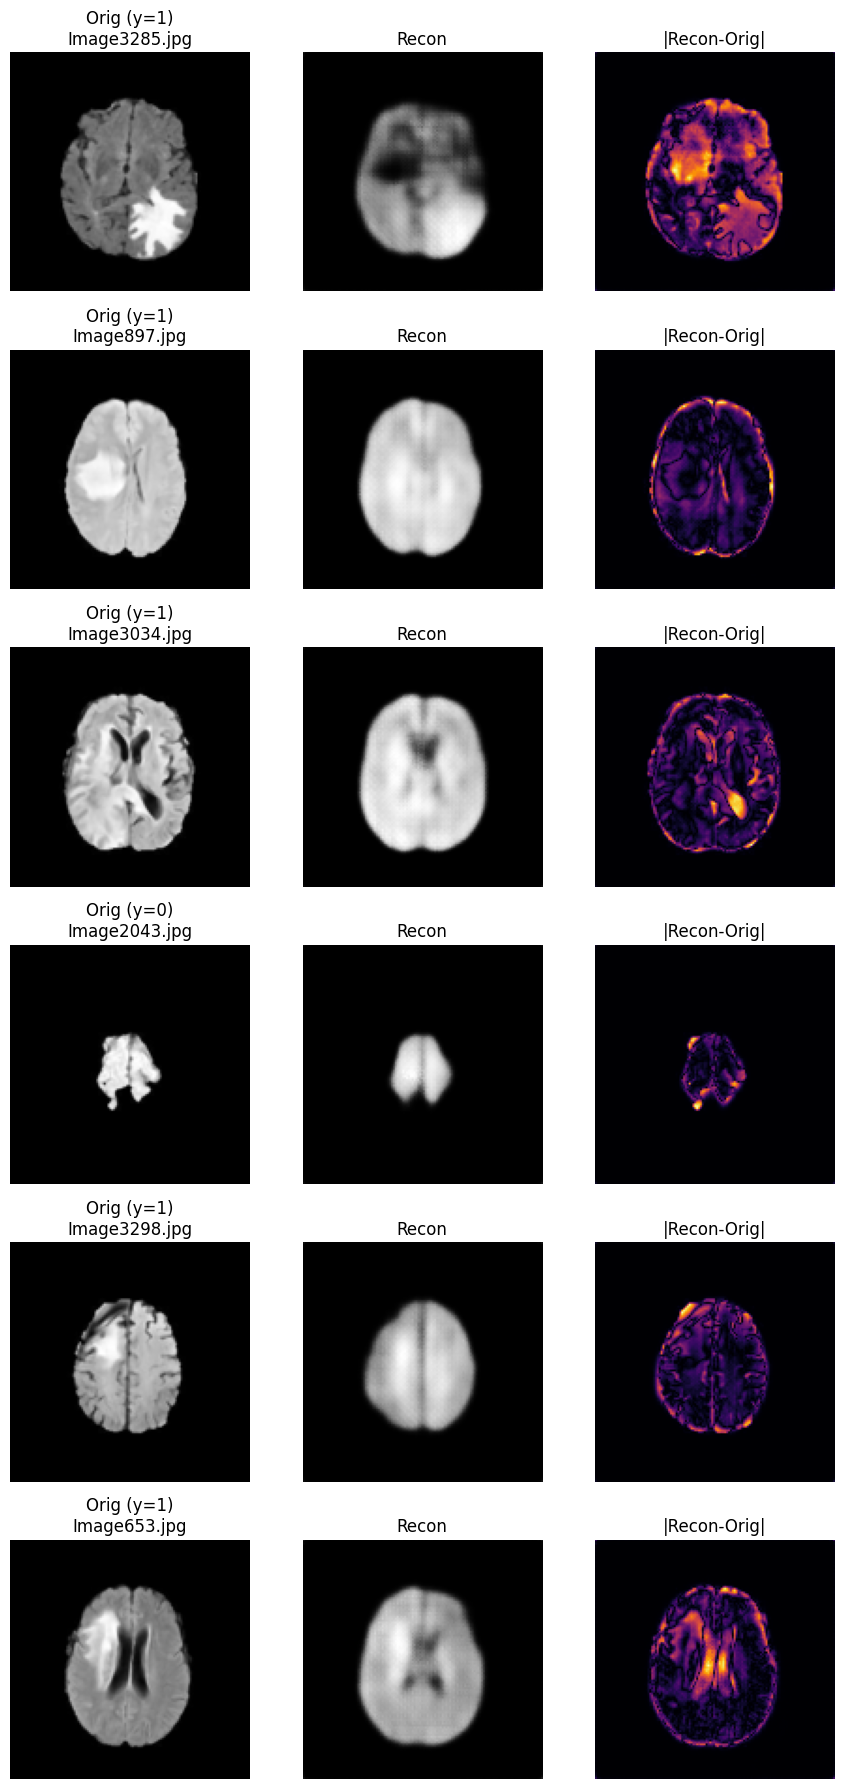

In [ ]:
# --- Visualization: original vs reconstruction vs error map
def denorm(x):
    # inverse normalize from [-1,1] -> [0,1]
    return (x + 1.0) * 0.5

@torch.no_grad()
def visualize_samples(model, dataset, n=6):
    # Show up to n samples; each sample gets a row with 3 columns: orig, recon, error
    n = min(n, len(dataset))
    idxs = np.random.choice(len(dataset), size=n, replace=False)
    plt.figure(figsize=(9, 3 * n))
    for i, idx in enumerate(idxs, 1):
        x, y, fp = dataset[idx]
        x = x.unsqueeze(0).to(device)
        xrec = model(x)
        err = (xrec - x).abs().squeeze().detach().cpu().numpy()
        x_np = denorm(x).squeeze().detach().cpu().numpy()
        xrec_np = denorm(xrec).squeeze().detach().cpu().numpy()

        # Place sample i on row i, three columns
        base = (i - 1) * 3
        plt.subplot(n, 3, base + 1); plt.imshow(x_np, cmap='gray'); plt.title(f"Orig (y={y})\n{Path(fp).name}"); plt.axis('off')
        plt.subplot(n, 3, base + 2); plt.imshow(xrec_np, cmap='gray'); plt.title("Recon"); plt.axis('off')
        plt.subplot(n, 3, base + 3); plt.imshow(err, cmap='inferno'); plt.title("|Recon-Orig|"); plt.axis('off')
    plt.tight_layout(); plt.show()

print("Samples from TEST set:")
visualize_samples(model, test_ds, n=6)

In [ ]:

# Save final model
torch.save(model.state_dict(), "conv_ae_final.pt")
print("Saved model weights: conv_ae_final.pt")


Saved model weights: conv_ae_final.pt


Rows: 800
                                            filepath  label  recon_mse  \
0  C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall ...      1   0.010962   
1  C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall ...      1   0.017152   
2  C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall ...      1   0.018038   
3  C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall ...      1   0.007627   
4  C:\Users\karls.KARL-LAPTOP\Documents\UNI\fall ...      1   0.025365   

   pred_anomaly  
0             0  
1             0  
2             0  
3             0  
4             1  
ROC-AUC: 0.6793
Acc: 0.499 | Prec: 0.861 | Rec: 0.300 | F1: 0.445
Confusion matrix:\n [[238  26]
 [375 161]]


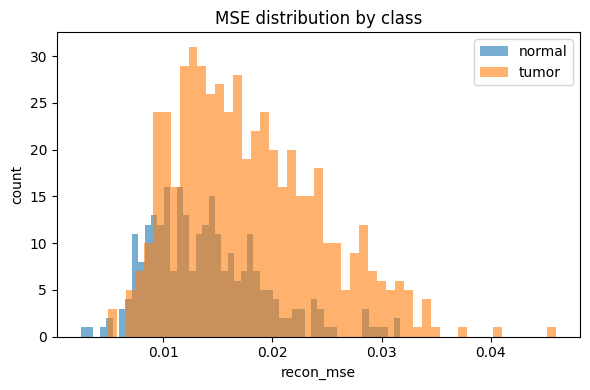

In [ ]:
# inspect_scores.py
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv("anomaly_scores_test.csv")
print("Rows:", len(df))
print(df.head())

y = df['label'].values
s = df['recon_mse'].values
pred = df['pred_anomaly'].values

auc = roc_auc_score(y, s) if len(np.unique(y))>1 else float('nan')
acc = accuracy_score(y, pred)
prec, rec, f1, _ = precision_recall_fscore_support(y, pred, average='binary', zero_division=0)
cm = confusion_matrix(y, pred)

print(f"ROC-AUC: {auc:.4f}")
print(f"Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
print("Confusion matrix:\\n", cm)

# Histogram of scores by class
plt.figure(figsize=(6,4))
plt.hist(s[y==0], bins=50, alpha=0.6, label='normal')
plt.hist(s[y==1], bins=50, alpha=0.6, label='tumor')
plt.legend(); plt.xlabel('recon_mse'); plt.ylabel('count'); plt.title('MSE distribution by class')
plt.tight_layout(); plt.show()